# CS-GY 9223-D: Deep Learning Homework 2

## Xception

Member 1: Anish Batra, ab8166

Member 2: Prashant Mahajan, prm349

### Importing libraries

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from importlib import reload
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import glob
from shutil import copyfile
from keras.models import load_model

Using TensorFlow backend.


### Check if GPU is available

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13510778217880047330
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14125001420809185457
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16751161472482582225
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15560753152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17256872866678036601
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


### Loading pretrained Xception model from keras

In [3]:
img_shape = (224, 224, 3)

xception_model = Xception(include_top=False, input_shape=img_shape)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# print(xception_model.summary())

### Loading Images and Augmentation

In [5]:
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
]


def append_ext(fn):
    return fn + ".jpg"


traindf = pd.read_csv('training_solutions_rev1.csv')

traindf["id"] = traindf['GalaxyID'].astype(str).apply(append_ext)

datagen = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.02)

train_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="images_training_rev1/",
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

valid_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="images_training_rev1/",
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 60347 images.
Found 1231 images.


### Adjust outputs layers of loaded model according to the given training data

In [6]:
# Flatten output of last layer before adding output layer (Dense layer)
x = Flatten()(xception_model.output)

# Add output layer (number of outputs = 37)
x = Dense(len(classes), activation='sigmoid')(x)

# Load the modified model
model = Model(inputs=xception_model.input, outputs=x)

### Visualize architecture of modified model; ready to be compiled

In [7]:
# print(model.summary())

### Fine tune all layers of the model | Adam Optimizer (decay)

In [8]:
for layer in model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(lr=0.001, decay=5e-4)

# optimizer = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

model.compile(optimizer, loss='mse', metrics=["accuracy"])

### Load callbacks - ModelCheckpoint, Callback, EarlyStopping

In [9]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='last_day_epochs/weights_adam.hdf5',
    verbose=2,
    save_best_only=True)

### Fit the model

In [10]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,
    callbacks=[history, checkpointer, early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
942/942 [==============================] - 1966s 2s/step - loss: 0.0130 - acc: 0.7513 - val_loss: 0.0093 - val_acc: 0.7862

Epoch 00001: val_loss improved from inf to 0.00932, saving model to last_day_epochs/weights_adam.hdf5
Epoch 2/30
942/942 [==============================] - 816s 866ms/step - loss: 0.0085 - acc: 0.7933 - val_loss: 0.0078 - val_acc: 0.8183

Epoch 00002: val_loss improved from 0.00932 to 0.00783, saving model to last_day_epochs/weights_adam.hdf5
Epoch 3/30
942/942 [==============================] - 816s 866ms/step - loss: 0.0077 - acc: 0.8039 - val_loss: 0.0075 - val_acc: 0.8295

Epoch 00003: val_loss improved from 0.00783 to 0.00751, saving model to last_day_epochs/weights_adam.hdf5
Epoch 4/30
942/942 [==============================] - 813s 863ms/step - loss: 0.0072 - acc: 0.8124 - val_loss: 0.0073 - val_acc: 0.8389

Epoch 00004: val_loss improved from 0.00751 to 0.00735, saving model to last_day_epochs/weig

### Plot training and validation loss

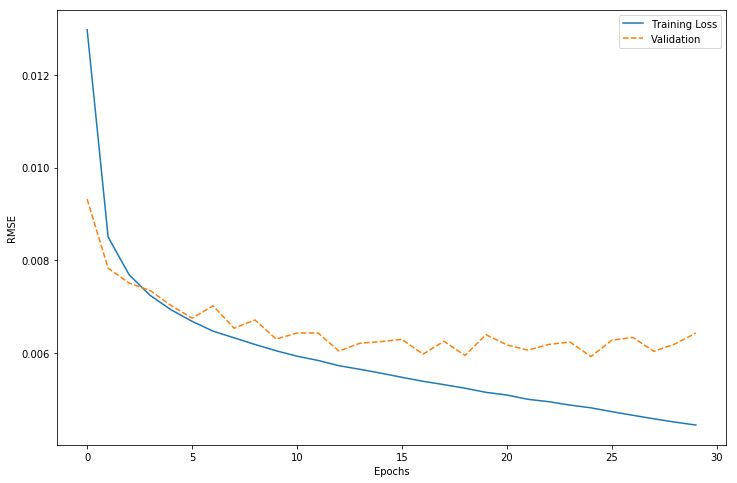

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
plt.plot(
    hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Load the best model from saved weights file

In [12]:
from keras.models import load_model

model = load_model('last_day_epochs/weights_adam.hdf5')

### Prepare ImageDataGenerator for test data

In [13]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    r"./xception_test",
    class_mode=None,
    color_mode="rgb",
    batch_size=1,
    target_size=(224, 224),
    seed=123,
    shuffle=False)

Found 600 images belonging to 1 classes.


### Make predictions on the test data

In [14]:
test_generator.reset()

predictions = model.predict_generator(
    test_generator,
    steps=test_generator.n / test_generator.batch_size,
    verbose=1)

print(predictions.shape)

600/600 [==============================] - 7s 12ms/step
(600, 37)


### Save results to .csv file

In [15]:
def get_id(fname):
    return fname.replace(".jpg", "").split("/")[1]


header = open('all_zeros_benchmark.csv', 'r').readlines()[0]

with open('xception_ensemble.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(test_generator.filenames)):
        id_ = (get_id(test_generator.filenames[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")